In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PowerTransformer, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, confusion_matrix, roc_curve

# from sklearn.pipeline import make_pipeline, Pipeline
from scipy.stats import skew
#from IPython.display import clear_output
import joblib

In [2]:
finaly_data = pd.read_excel("Продажи с касаниями клиентов.xlsx", index_col=0)

In [3]:
data = finaly_data.copy()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146016 entries, 0 to 146015
Data columns (total 44 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   AktVipRabot                  2375 non-null    object        
 1   Data                         2375 non-null    datetime64[ns]
 2   SummaAktaVipRabot            2375 non-null    float64       
 3   Quantity                     2375 non-null    float64       
 4   KodStrokiAkt                 2375 non-null    float64       
 5   ZakazKlienta                 2375 non-null    object        
 6   NomenklaturaKod              2375 non-null    object        
 7   Nomenklatura                 2375 non-null    object        
 8   ZakazData                    146016 non-null  datetime64[ns]
 9   PartnerKod                   146016 non-null  object        
 10  OsnovnoyManager              146016 non-null  object        
 11  BiznesRegion              

# Обработка данных

## Проверим, нужно ли изменять кол-во объектов в целевой переменной в мажоритарном и Миноритарном классах

In [5]:
display(data['ПродажаСостоялась'])

0         Нет
1         Нет
2         Нет
3         Нет
4         Нет
         ... 
146011     Да
146012     Да
146013     Да
146014     Да
146015     Да
Name: ПродажаСостоялась, Length: 146016, dtype: object

C:\Users\Jon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


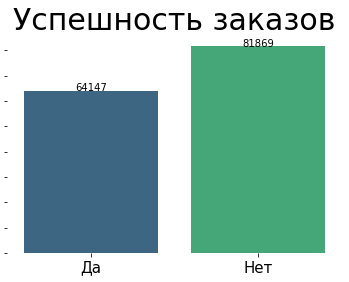

In [6]:
fig, ax = plt.subplots()
g = sns.countplot(data['ПродажаСостоялась'], palette='viridis')

g.set_xticklabels(['Да', 'Нет'])
g.set_yticklabels([])


# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Успешность заказов', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

In [7]:
# Вывод данные сбалансирвоанны, измененять кол-во объектов Миноритарного и 
# Мажоритарного классов не трубется

## Удалим не нужные и коррелирующие столбцы

In [5]:
del_list = [
    # Столбцы Услуг, не их анализируем    
    'AktVipRabot', 'Data', 'SummaAktaVipRabot', 'Quantity', 'KodStrokiAkt',
    'ZakazKlienta', 'NomenklaturaKod', 'Nomenklatura',
    # Столбцы коррелирующие с Успех
    'RealizSsilka', 'DataRealiz', 'SummaRealiz', 'ProdanoShtuk', 
    'KodStrokiRealiz', 'PrichinaOtmeny', 'Otmeneno', 'VariantObecpech',
    # Есть только у действующих Заказов
    'SummaZakaza',
    # Столбец ключ с предыдущих этапов
    'KodStrokiZakaz',
    # Столбец дубликат
    'NomenklaturaRealizAndZakaz']

for elem in del_list:
    del data[elem]

## Удалим столбцы с большим кол-вом уникальных значений

In [6]:
object_columns = [c for c in data.columns if data[c].dtype.name == 'object']
print(f'В данных всего строк {len(data)}')
for col in object_columns:
    print(
        f'Всего значений {"%5.f" %data[col].unique().shape[0]} это {"%3.2f" % (data[col].unique().shape[0] / len(data)*100)}% уникальных записей в: {col} от всего набора'
    )

В данных всего строк 146016
Всего значений  4127 это 2.83% уникальных записей в: PartnerKod от всего набора
Всего значений    12 это 0.01% уникальных записей в: OsnovnoyManager от всего набора
Всего значений   114 это 0.08% уникальных записей в: BiznesRegion от всего набора
Всего значений     2 это 0.00% уникальных записей в: KreditIliPredoplata от всего набора
Всего значений     2 это 0.00% уникальных записей в: StatusZakaza от всего набора
Всего значений     5 это 0.00% уникальных записей в: SposobDostavki от всего набора
Всего значений  1581 это 1.08% уникальных записей в: NomenklaturaKodRealAndZakaz от всего набора
Всего значений    46 это 0.03% уникальных записей в: VidNomenklatury от всего набора
Всего значений    46 это 0.03% уникальных записей в: KodTNVED от всего набора
Всего значений     7 это 0.00% уникальных записей в: VidCeny от всего набора
Всего значений     2 это 0.00% уникальных записей в: StavkaNDS от всего набора
Всего значений 38433 это 26.32% уникальных записей в: 

In [7]:
# Много уникальных значений
del data['LinkOrder']

## Обработка дат

### Выделим дату в категориальный тип данных

In [8]:
data['Год + Месяц'] = None
for number, series in data.iterrows():
    data.at[number, 'Год + Месяц'] = f'{str(series["ZakazData"].year)}_{str(series["ZakazData"].month)}'

### Удалим столбцы с типом данных Дата

In [9]:
# Столбцы дат, Forest не работает стипом даттых "Дата"
del_list = [
    'JelaemayaDataOtgruzki', 'DataOtgruzki', 'SrokPostavki', 'ZakazData']

for elem in del_list:
    del data[elem]

## Обработка пропусков

In [10]:
def mis_value(data: pd.DataFrame) -> None:
    misses = ['', 'nan', 'none', 'None']
    for col in data.columns:
        for mis in misses:
            sum_miss = data.loc[data[col] == mis].shape[0]
            if sum_miss > 0:
                print(f"Column {col} has {sum_miss} passes over the key {mis}")
    print(data.isnull().sum())

In [11]:
mis_value(data)

PartnerKod                          0
OsnovnoyManager                     0
BiznesRegion                        0
KreditIliPredoplata                 0
StatusZakaza                        0
SposobDostavki                      0
NomenklaturaKodRealAndZakaz         0
VidNomenklatury                     0
KodTNVED                            0
ZakazanoShtuk                       0
VidCeny                             0
Cena                               20
StavkaNDS                           0
SummaZakazano                      24
RastoynieOtNSK                      0
otMoscow                            0
ПродажаСостоялась                   0
ItogoProcentSkidki             145401
cals                                0
emails                              0
Год + Месяц                         0
dtype: int64


In [12]:
# Cena и SummaZakazano заменим медианой
data['Cena'].fillna(value=pd.DataFrame.median(data['Cena']), inplace=True)
data['SummaZakazano'].fillna(value=pd.DataFrame.median(
    data['SummaZakazano']), inplace=True)

# ItogoProcentSkidki заменим нулем
data['ItogoProcentSkidki'].fillna(value=0, inplace=True)

In [13]:
mis_value(data)

PartnerKod                     0
OsnovnoyManager                0
BiznesRegion                   0
KreditIliPredoplata            0
StatusZakaza                   0
SposobDostavki                 0
NomenklaturaKodRealAndZakaz    0
VidNomenklatury                0
KodTNVED                       0
ZakazanoShtuk                  0
VidCeny                        0
Cena                           0
StavkaNDS                      0
SummaZakazano                  0
RastoynieOtNSK                 0
otMoscow                       0
ПродажаСостоялась              0
ItogoProcentSkidki             0
cals                           0
emails                         0
Год + Месяц                    0
dtype: int64


## Нужно-ли удалить одно из: VidNomenklatury, KodTNVED
Эти столбцы описывают номенклатуру, только VidNomenklatury установлен вручную
а KodTNVED получен от поставщика

### Проверка через dummies
* Для этого фичи переведем в dummies переменные и проверим корреляцию

In [17]:
dummies = data[['VidNomenklatury', 'KodTNVED']].copy()
dummies

,VidNomenklatury,KodTNVED
0,Огнетушители (с февраля),8424100000
1,Товары,8424900000
2,Огнетушители (с февраля),8424100000
3,Товары,7609000000
4,Подставки под огнетушители ( с февраля),9403105809
...,...,...
146011,Шкафы пожарные (с февраля),НеУказано
146012,Шкафы пожарные (с февраля),9403105809
146013,Огнетушители (с февраля),8424100000
146014,Огнетушители (с февраля),8424100000


In [18]:
dummies_data = pd.get_dummies(dummies)
dummies_data

,VidNomenklatury_Автотовары (с февраля),VidNomenklatury_Баллоны для газов (с февраля),VidNomenklatury_Веревки и веревочные лестницы (с февраля),VidNomenklatury_Водопенное оборудование (с февраля),VidNomenklatury_Все для планов эвакуации (с февраля),VidNomenklatury_Гидранты (с февраля),VidNomenklatury_Готовая продукция ЛБ (43),VidNomenklatury_Доставка,"VidNomenklatury_ЗПУ, индикаторы и другие части (с февраля)",VidNomenklatury_Заряды к огнетушителям (с февраля),...,KodTNVED_8481806100,KodTNVED_8481807900,KodTNVED_8481808508,KodTNVED_8504405500,KodTNVED_8507302009,KodTNVED_8513100000,KodTNVED_9402900000,KodTNVED_9403105809,KodTNVED_9403109300,KodTNVED_НеУказано
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146011,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
146012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
146013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146014,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Построим матрицу корреляции

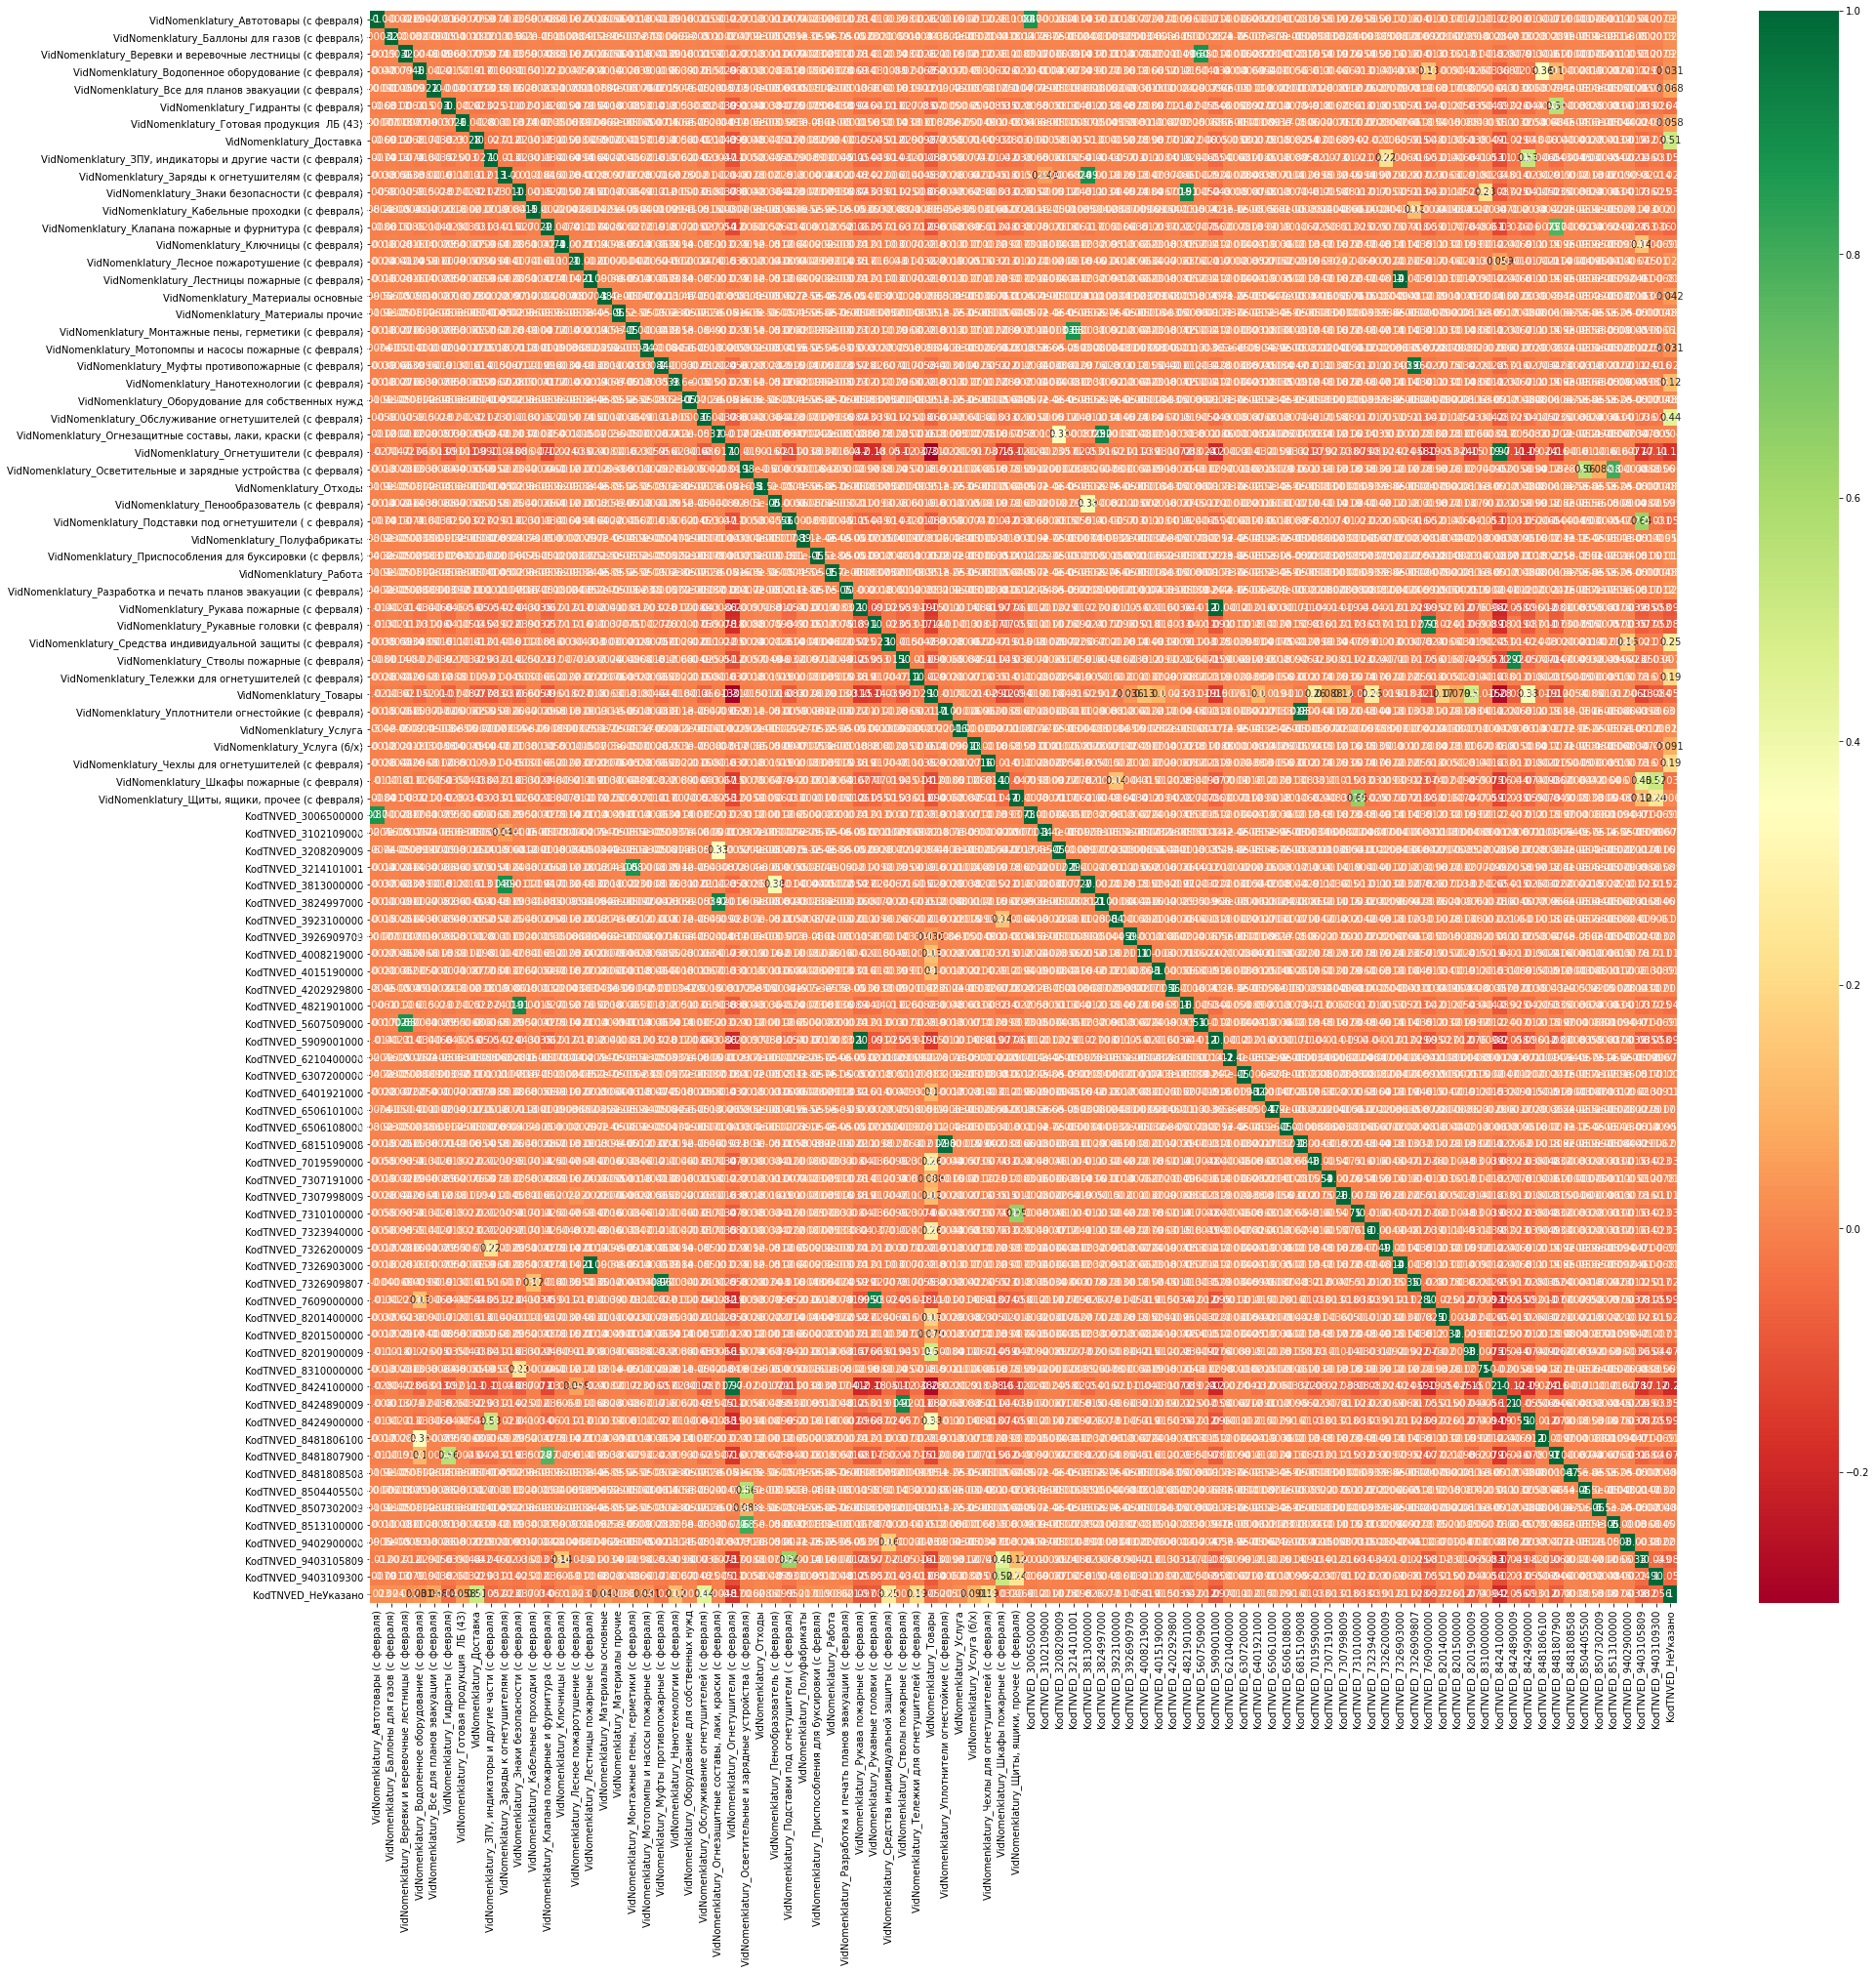

In [19]:
corrmat = dummies_data.corr(method='pearson')
top_corr_features = corrmat.index
plt.figure(figsize=(30,30))
g=sns.heatmap(dummies_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [20]:
# Вывод Есть корреляция м/у данными

#### Построим тестовое дерево на dummies

In [21]:
dummies_data = pd.concat([data['ПродажаСостоялась'],dummies_data], axis=1)
dummies_data

,ПродажаСостоялась,VidNomenklatury_Автотовары (с февраля),VidNomenklatury_Баллоны для газов (с февраля),VidNomenklatury_Веревки и веревочные лестницы (с февраля),VidNomenklatury_Водопенное оборудование (с февраля),VidNomenklatury_Все для планов эвакуации (с февраля),VidNomenklatury_Гидранты (с февраля),VidNomenklatury_Готовая продукция ЛБ (43),VidNomenklatury_Доставка,"VidNomenklatury_ЗПУ, индикаторы и другие части (с февраля)",...,KodTNVED_8481806100,KodTNVED_8481807900,KodTNVED_8481808508,KodTNVED_8504405500,KodTNVED_8507302009,KodTNVED_8513100000,KodTNVED_9402900000,KodTNVED_9403105809,KodTNVED_9403109300,KodTNVED_НеУказано
0,Нет,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Нет,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Нет,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Нет,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Нет,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146011,Да,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
146012,Да,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
146013,Да,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146014,Да,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
X = dummies_data.drop(columns='ПродажаСостоялась')
y = dummies_data['ПродажаСостоялась']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

forest = RandomForestClassifier(random_state=152, oob_score=True)
forest.fit(X_train, y_train)

print("Правильность на обучающей выборке: {:.3f}".format(
    forest.score(X_train, y_train)))
print("OOB оценка правильности: {:.2f}".format(forest.oob_score_))
print("Правильность на контрольной выборке: {:.3f}".format(
    forest.score(X_test, y_test)))

Правильность на обучающей выборке: 0.601
OOB оценка правильности: 0.60
Правильность на контрольной выборке: 0.602


#### Посчитаем вклад по типу переменной

In [23]:
# Создаем объект с названиями предикторов
feat_labels = X.columns
# Создаем объект со значениями важностей, вычисленными моделью forest
importances = forest.feature_importances_
# Задаем сортировку значений важности и сопоставляем названия предикторов важностям
indices = np.argsort(importances)[::-1]
sum_KodTNVED = 0
sum_Vidnom = 0
for f in range(X_train.shape[1]):
    print("%3d) %-*s %f" %
          (f + 1, 80, feat_labels[indices[f]], importances[indices[f]]))
    if 'KodTNVED' in feat_labels[indices[f]]:
        sum_KodTNVED += importances[indices[f]]
    else:
        sum_Vidnom += importances[indices[f]]

  1) VidNomenklatury_Обслуживание огнетушителей (с февраля)                           0.313149
  2) KodTNVED_8424900000                                                              0.110390
  3) KodTNVED_7307998009                                                              0.054290
  4) VidNomenklatury_Огнетушители (с февраля)                                         0.051077
  5) KodTNVED_НеУказано                                                               0.049271
  6) VidNomenklatury_Подставки под огнетушители ( с февраля)                          0.032783
  7) VidNomenklatury_ЗПУ, индикаторы и другие части (с февраля)                       0.031916
  8) KodTNVED_8481807900                                                              0.028834
  9) KodTNVED_8424100000                                                              0.028224
 10) VidNomenklatury_Товары                                                           0.028011
 11) KodTNVED_9403105809                          

In [24]:
print(sum_KodTNVED)
print(sum_Vidnom)

# Вывод, VidNomenklatury лучше объясняет модель

0.3884820410098739
0.611517958990126


### Проверка без обработки признаков в dummies

In [25]:
time_data = data[['VidNomenklatury', 'KodTNVED']].copy()
time_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146016 entries, 0 to 146015
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   VidNomenklatury  146016 non-null  object
 1   KodTNVED         146016 non-null  object
dtypes: object(2)
memory usage: 7.4+ MB


In [26]:
categorical_columns = [c for c in time_data.columns if time_data[c].dtype.name == 'object']
categorical_columns

['VidNomenklatury', 'KodTNVED']

In [27]:
for colum in categorical_columns:
    print(colum)
    label = LabelEncoder()
    # Обучим Encoder
    label.fit(time_data[colum].drop_duplicates())
    # Применим обученный Encoder для транформации, запишем данные в df
    time_data[colum] = label.transform(time_data[colum])

VidNomenklatury
KodTNVED


In [28]:
time_data = pd.concat([time_data, data['ПродажаСостоялась']], axis=1)
time_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146016 entries, 0 to 146015
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   VidNomenklatury    146016 non-null  int32 
 1   KodTNVED           146016 non-null  int32 
 2   ПродажаСостоялась  146016 non-null  object
dtypes: int32(2), object(1)
memory usage: 7.4+ MB


In [29]:
X = time_data.drop(columns='ПродажаСостоялась')
y = time_data['ПродажаСостоялась']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

forest = RandomForestClassifier(random_state=152, oob_score=True)
forest.fit(X_train, y_train)

print("Правильность на обучающей выборке: {:.3f}".format(
    forest.score(X_train, y_train)))
print("OOB оценка правильности: {:.2f}".format(forest.oob_score_))
print("Правильность на контрольной выборке: {:.3f}".format(
    forest.score(X_test, y_test)))

Правильность на обучающей выборке: 0.601
OOB оценка правильности: 0.60
Правильность на контрольной выборке: 0.602


In [30]:
# Создаем объект с названиями предикторов
feat_labels = X.columns
# Создаем объект со значениями важностей, вычисленными моделью forest
importances = forest.feature_importances_
# Задаем сортировку значений важности и сопоставляем названия предикторов важностям
indices = np.argsort(importances)[::-1]
sum_KodTNVED = 0
sum_Vidnom = 0

for f in range(X_train.shape[1]):
    print("%3d) %-*s %f" %
          (f + 1, 80, feat_labels[indices[f]], importances[indices[f]]))
    if 'KodTNVED' in feat_labels[indices[f]]:
        sum_KodTNVED += importances[indices[f]]
    else:
        sum_Vidnom += importances[indices[f]]

  1) VidNomenklatury                                                                  0.585301
  2) KodTNVED                                                                         0.414699


In [31]:
print(sum_KodTNVED)
print(sum_Vidnom)

# Вывод, KodTNVED важнее чем VidNomenklatury

0.4146991380925964
0.5853008619074037


### Удалим менее важный предиктор
Напомню при dummi результаты:
    KodTNVED        - 0.41469
    VidNomenklatury - 0.58530
Т.к. алгоритм Forest способен сам ветвить (dummi), считаю столбец VidNomenklatury более предпочтительней

In [14]:
del data['KodTNVED']

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146016 entries, 0 to 146015
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   PartnerKod                   146016 non-null  object 
 1   OsnovnoyManager              146016 non-null  object 
 2   BiznesRegion                 146016 non-null  object 
 3   KreditIliPredoplata          146016 non-null  object 
 4   StatusZakaza                 146016 non-null  object 
 5   SposobDostavki               146016 non-null  object 
 6   NomenklaturaKodRealAndZakaz  146016 non-null  object 
 7   VidNomenklatury              146016 non-null  object 
 8   ZakazanoShtuk                146016 non-null  float64
 9   VidCeny                      146016 non-null  object 
 10  Cena                         146016 non-null  float64
 11  StavkaNDS                    146016 non-null  object 
 12  SummaZakazano                146016 non-null  float64
 13 

# Построим Деревья

## Используя LabelEncoder

### Перекодируем

In [16]:
def work_with_categorical_columns(data, cat_col, target, target_label, label_dict):
    # Сделаем копию df
    label_encoded_data = data[cat_col].copy()
    # Пойдем по столбцам
    for colum in label_encoded_data.columns:
        label = LabelEncoder()
        # Обучим Encoder
        label.fit(label_encoded_data[colum].drop_duplicates())
        label_dict[colum] = label
        # Применим обученный Encoder для транформации, запишем данные в df
        label_encoded_data[colum] = label.transform(label_encoded_data[colum])

    return(label_encoded_data, label_dict)

In [17]:
# Получим списки по видам
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
print(f'Числовые столбы:\n{numerical_columns}')
print(f'\nКатегориальные столбы:\n{categorical_columns}')

Числовые столбы:
['ZakazanoShtuk', 'Cena', 'SummaZakazano', 'RastoynieOtNSK', 'otMoscow', 'ItogoProcentSkidki', 'cals', 'emails']

Категориальные столбы:
['PartnerKod', 'OsnovnoyManager', 'BiznesRegion', 'KreditIliPredoplata', 'StatusZakaza', 'SposobDostavki', 'NomenklaturaKodRealAndZakaz', 'VidNomenklatury', 'VidCeny', 'StavkaNDS', 'ПродажаСостоялась', 'Год + Месяц']


In [36]:
# Числовые данные не требуют преобразований (особенность Forest)

In [18]:
label_dict = dict() # Запишем объекты labelEncoder
# Преобразование с categorical_columns для newDF
label_encoded_data, label_dict = work_with_categorical_columns(
    data, categorical_columns, 'ПродажаСостоялась', 'OsnovnoyManager', label_dict)

# Теперь нужно склеить результат работы в новый DF:
encoded_data = pd.concat([data[numerical_columns], label_encoded_data], axis=1)

### Построим дерево решений, оценим

In [38]:
X = encoded_data.drop(columns='ПродажаСостоялась')
y = encoded_data['ПродажаСостоялась']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

forest = RandomForestClassifier(random_state=152, oob_score=True)
forest.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=152)

In [39]:
print("Правильность на обучающей выборке: {:.3f}".format(forest.score(X_train, y_train)))
print("Правильность на контрольной выборке: {:.3f}".format(forest.score(X_test, y_test)))

Правильность на обучающей выборке: 0.996
Правильность на контрольной выборке: 0.849


In [40]:
print("Правильность на обучающей выборке: {:.3f}".format(
    forest.score(X_train, y_train)))
print("OOB оценка правильности: {:.2f}".format(forest.oob_score_))
print("Правильность на контрольной выборке: {:.3f}".format(
    forest.score(X_test, y_test)))

Правильность на обучающей выборке: 0.996
OOB оценка правильности: 0.84
Правильность на контрольной выборке: 0.849


In [41]:
print("AUC на обучающей выборке: {:.3f}".
      format(roc_auc_score(y_train, forest.predict_proba(X_train)[:, 1])))
print("AUC на контрольной выборке: {:.3f}".
      format(roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])))

AUC на обучающей выборке: 1.000
AUC на контрольной выборке: 0.923


## Важность предикторов

In [42]:
# Создаем объект с названиями предикторов
feat_labels = X.columns
# Создаем объект со значениями важностей, вычисленными моделью forest
importances = forest.feature_importances_
# Задаем сортировку значений важности и сопоставляем названия предикторов важностям
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%3d) %-*s %f" %
          (f + 1, 80, feat_labels[indices[f]], importances[indices[f]]))

  1) PartnerKod                                                                       0.140893
  2) Год + Месяц                                                                      0.112964
  3) SummaZakazano                                                                    0.112231
  4) Cena                                                                             0.087475
  5) NomenklaturaKodRealAndZakaz                                                      0.073691
  6) emails                                                                           0.072583
  7) ZakazanoShtuk                                                                    0.071636
  8) VidNomenklatury                                                                  0.046078
  9) OsnovnoyManager                                                                  0.043206
 10) otMoscow                                                                         0.042224
 11) BiznesRegion                                 

## Используя dummies

### Перекодируем

In [19]:
data['ПродажаСостоялась'].unique()

array(['Нет', 'Да'], dtype=object)

In [20]:
# print("Исходные переменные:\n", list(data.columns), "\n")
data_dummies_full = pd.get_dummies(data[categorical_columns])
print("Переменные после get_dummies:\n", list(data_dummies_full.columns))

Переменные после get_dummies:
 ['PartnerKod_00-00000055', 'PartnerKod_00-00000057', 'PartnerKod_00-00000059', 'PartnerKod_00-00000060', 'PartnerKod_00-00000061', 'PartnerKod_00-00000062', 'PartnerKod_00-00000063', 'PartnerKod_00-00000064', 'PartnerKod_00-00000065', 'PartnerKod_00-00000066', 'PartnerKod_00-00000067', 'PartnerKod_00-00000068', 'PartnerKod_00-00000069', 'PartnerKod_00-00000070', 'PartnerKod_00-00000071', 'PartnerKod_00-00000072', 'PartnerKod_00-00000073', 'PartnerKod_00-00000074', 'PartnerKod_00-00000075', 'PartnerKod_00-00000076', 'PartnerKod_00-00000077', 'PartnerKod_00-00000080', 'PartnerKod_00-00000081', 'PartnerKod_00-00000082', 'PartnerKod_00-00000083', 'PartnerKod_00-00000086', 'PartnerKod_00-00000087', 'PartnerKod_00-00000088', 'PartnerKod_00-00000089', 'PartnerKod_00-00000090', 'PartnerKod_00-00000091', 'PartnerKod_00-00000092', 'PartnerKod_00-00000093', 'PartnerKod_00-00000095', 'PartnerKod_00-00000096', 'PartnerKod_00-00000097', 'PartnerKod_00-00000098', 'Partn

In [21]:
# Теперь нужно склеить результат работы в новый DF:
dummies_data = pd.concat([data[numerical_columns], data_dummies_full], axis=1)

### Построим дерево решений

In [46]:
X = dummies_data.drop(columns=['ПродажаСостоялась_Да', 'ПродажаСостоялась_Нет'])
y = encoded_data['ПродажаСостоялась']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

forest = RandomForestClassifier(random_state=152, oob_score=True)
forest.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=152)

In [47]:
print("Правильность на обучающей выборке: {:.3f}".format(forest.score(X_train, y_train)))
print("Правильность на контрольной выборке: {:.3f}".format(forest.score(X_test, y_test)))

Правильность на обучающей выборке: 0.996
Правильность на контрольной выборке: 0.863


In [48]:
print("Правильность на обучающей выборке: {:.3f}".format(
    forest.score(X_train, y_train)))
print("OOB оценка правильности: {:.2f}".format(forest.oob_score_))
print("Правильность на контрольной выборке: {:.3f}".format(
    forest.score(X_test, y_test)))

Правильность на обучающей выборке: 0.996
OOB оценка правильности: 0.85
Правильность на контрольной выборке: 0.863


In [49]:
print("AUC на обучающей выборке: {:.3f}".
      format(roc_auc_score(y_train, forest.predict_proba(X_train)[:, 1])))
print("AUC на контрольной выборке: {:.3f}".
      format(roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])))

AUC на обучающей выборке: 1.000
AUC на контрольной выборке: 0.932


### Посчитаем важность предикторов по типам переменных

In [50]:
# Создаем объект с названиями предикторов
feat_labels = X.columns
# Создаем объект со значениями важностей, вычисленными моделью forest
importances = forest.feature_importances_
# Задаем сортировку значений важности и сопоставляем названия предикторов важностям
indices = np.argsort(importances)[::-1]
sum_PartnerKod = 0
sum_OsnovnoyManager = 0
sum_BiznesRegion = 0
sum_KreditIliPredoplata = 0
sum_StatusZakaza = 0
sum_SposobDostavki = 0
sum_VidNomenklatury = 0
sum_VidCeny = 0
sum_StavkaNDS = 0
sum_Год_Месяц = 0

for f in range(X_train.shape[1]):
    print("%3d) %-*s %f" %
          (f + 1, 80, feat_labels[indices[f]], importances[indices[f]]))
    if 'PartnerKod' in feat_labels[indices[f]]:
        sum_PartnerKod += importances[indices[f]]
    elif 'OsnovnoyManager' in feat_labels[indices[f]]:
        sum_OsnovnoyManager += importances[indices[f]]
    elif 'BiznesRegion' in feat_labels[indices[f]]:
        sum_BiznesRegion += importances[indices[f]]
    elif 'KreditIliPredoplata' in feat_labels[indices[f]]:
        sum_KreditIliPredoplata += importances[indices[f]]
    elif 'StatusZakaza' in feat_labels[indices[f]]:
        sum_StatusZakaza += importances[indices[f]]
    elif 'SposobDostavki' in feat_labels[indices[f]]:
        sum_SposobDostavki += importances[indices[f]]
    elif 'VidNomenklatury' in feat_labels[indices[f]]:
        sum_VidNomenklatury += importances[indices[f]]
    elif 'VidCeny' in feat_labels[indices[f]]:
        sum_VidCeny += importances[indices[f]]
    elif 'StavkaNDS' in feat_labels[indices[f]]:
        sum_StavkaNDS += importances[indices[f]]
    elif 'Год + Месяц' in feat_labels[indices[f]]:
        sum_Год_Месяц += importances[indices[f]]

  1) SummaZakazano                                                                    0.070938
  2) ZakazanoShtuk                                                                    0.054638
  3) Cena                                                                             0.051528
  4) emails                                                                           0.047152
  5) otMoscow                                                                         0.022432
  6) RastoynieOtNSK                                                                   0.020264
  7) KreditIliPredoplata_Да                                                           0.018692
  8) KreditIliPredoplata_Нет                                                          0.016016
  9) BiznesRegion_Регион не указан                                                    0.011537
 10) SposobDostavki_Самовывоз                                                         0.010707
 11) SposobDostavki_Силами перевозчика по адресу  

1261) PartnerKod_00-00002981                                                           0.000056
1262) NomenklaturaKodRealAndZakaz_00000000292                                          0.000056
1263) NomenklaturaKodRealAndZakaz_00000003245                                          0.000056
1264) PartnerKod_000003426                                                             0.000056
1265) PartnerKod_00-00002212                                                           0.000056
1266) PartnerKod_000004379                                                             0.000056
1267) PartnerKod_000004072                                                             0.000056
1268) PartnerKod_00-00002180                                                           0.000056
1269) PartnerKod_000006758                                                             0.000056
1270) NomenklaturaKodRealAndZakaz_00000000786                                          0.000056
1271) NomenklaturaKodRealAndZakaz_000000

2243) PartnerKod_00-00002185                                                           0.000016
2244) PartnerKod_000005832                                                             0.000016
2245) PartnerKod_000005552                                                             0.000016
2246) PartnerKod_00-00002674                                                           0.000016
2247) PartnerKod_00-00000275                                                           0.000016
2248) NomenklaturaKodRealAndZakaz_00000006145                                          0.000016
2249) NomenklaturaKodRealAndZakaz_00-00001175                                          0.000016
2250) PartnerKod_00-00000446                                                           0.000016
2251) PartnerKod_00-00000789                                                           0.000016
2252) PartnerKod_00-00002560                                                           0.000016
2253) PartnerKod_000000622              

3573) BiznesRegion_Новгородская обл                                                    0.000004
3574) PartnerKod_00-00001653                                                           0.000004
3575) PartnerKod_00-00001773                                                           0.000004
3576) PartnerKod_00-00001538                                                           0.000004
3577) PartnerKod_000004372                                                             0.000004
3578) NomenklaturaKodRealAndZakaz_00000004764                                          0.000004
3579) PartnerKod_00-00002006                                                           0.000004
3580) PartnerKod_000006440                                                             0.000004
3581) NomenklaturaKodRealAndZakaz_00000002231                                          0.000004
3582) PartnerKod_000004913                                                             0.000004
3583) PartnerKod_00-00002955            

4571) PartnerKod_00-00000142                                                           0.000001
4572) NomenklaturaKodRealAndZakaz_00-00000570                                          0.000001
4573) NomenklaturaKodRealAndZakaz_00000008074                                          0.000001
4574) PartnerKod_00-00002110                                                           0.000001
4575) PartnerKod_000000221                                                             0.000001
4576) PartnerKod_00-00001154                                                           0.000001
4577) PartnerKod_00-00001884                                                           0.000001
4578) PartnerKod_00-00002965                                                           0.000001
4579) NomenklaturaKodRealAndZakaz_00000000719                                          0.000001
4580) PartnerKod_00-00002473                                                           0.000001
4581) NomenklaturaKodRealAndZakaz_00-000

In [51]:
print(
    f'PartnerKod - {sum_PartnerKod}\n',
    f'OsnovnoyManager - {sum_OsnovnoyManager}\n',
    f'BiznesRegion - {sum_BiznesRegion}\n',
    f'KreditIliPredoplata - {sum_KreditIliPredoplata}\n',
    f'StatusZakaza - {sum_StatusZakaza}\n',
    f'SposobDostavki - {sum_SposobDostavki}\n',
    f'VidNomenklatury - {sum_VidNomenklatury}\n',
    f'VidCeny - {sum_VidCeny}\n',
    f'StavkaNDS - {sum_StavkaNDS}\n',
    f'Год_Месяц - {sum_Год_Месяц}')

PartnerKod - 0.2268415018501148
 OsnovnoyManager - 0.032350554997974935
 BiznesRegion - 0.06224576968815709
 KreditIliPredoplata - 0.034707864755341905
 StatusZakaza - 0.002386373512734125
 SposobDostavki - 0.021479348556035626
 VidNomenklatury - 0.05474085390603625
 VidCeny - 0.026087459077680494
 StavkaNDS - 0.0031576391590314723
 Год_Месяц - 0.12529693322402138


## Вывод 
Mодель с dummies преобразованными категориальными переменными точнее
(на 0,023).

Но нужно понимать что для приминения такой модели нужна чуть более сложная 
транформация новых данных

# Поиск оптимальных параметров

In [ ]:
# Отключаем предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# Создаем экземляр класса StratifiedKFold 
strat = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

## trees_grid

In [53]:
# Создаем списки для сохранения правильности на обучающей и контрольной выборках
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [100, 1000, 2000, 3000]

# Строим модели с разным количеством деревьев
for ntrees in trees_grid:
    print(f'\nНачали работать с {ntrees} деревьями\n')
    rf = RandomForestClassifier(
        n_estimators=ntrees, random_state=42, n_jobs=-1, verbose=1)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in strat.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rf.fit(X_train, y_train)
        temp_train_acc.append(rf.score(X_train, y_train))
        temp_test_acc.append(rf.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

# Преобразуем списки в массивы NumPy
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Наилучшее значение правильности перекрестной проверки равно {:.2f}% и достигается при {} деревьях".format(max(test_acc.mean(axis=1))*100,
                                                                                                                 trees_grid[np.argmax(test_acc.mean(axis=1))]))


Начали работать с 100 деревьями



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   47.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0


Начали работать с 1000 деревьями



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  7.8min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    3.4s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    6.3s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    8.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elaps


Начали работать с 2000 деревьями



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 15.9min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    5.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    8.9s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:   13.5s
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed:   18.2s
[Parallel(n_job


Начали работать с 3000 деревьями



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 23.7min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    3.7s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    6.7s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:   10.5s
[Parallel(n_job

Наилучшее значение правильности перекрестной проверки равно 85.99% и достигается при 3000 деревьях


[Parallel(n_jobs=16)]: Done 3000 out of 3000 | elapsed:   13.5s finished


Text(0.5, 0, 'Количество деревьев')

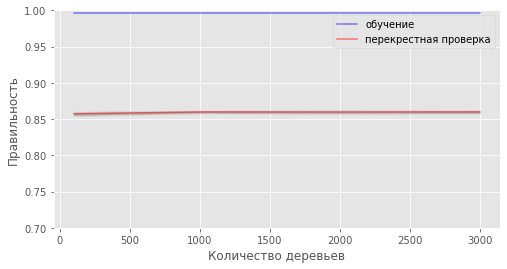

In [54]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', 
        label='обучение')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', 
        label='перекрестная проверка')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.70,1.00])
ax.set_ylabel("Правильность")
ax.set_xlabel("Количество деревьев")

In [55]:
# Прирост м/у 1000 и 3000 очень маленький, за базу приму [1000, 2000, 3000]

## max_features
Поиск проводить не буду, т.к. фич в наборе данных нет, отсюда считаю что нужны все переменные.

## max_depth_grid

In [56]:
# Создаем списки для сохранения AUC на обучающей и контрольной выборках
train_auc = []
test_auc = []
temp_train_auc = []
temp_test_auc = []
max_depth_grid = [120, 160, 200]

# Строим модели с разным значением глубины
for max_depth in max_depth_grid:
    print(f'\nНачали строить модель максимальной глубиной {max_depth}\n')
    rf = RandomForestClassifier(
        n_estimators= trees_grid[np.argmax(test_acc.mean(axis=1))], 
        random_state=42, 
        n_jobs=-1, 
        max_depth=max_depth, 
        verbose=1)
    temp_train_auc = []
    temp_test_auc = []
    for train_index, test_index in strat.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rf.fit(X_train, y_train)
        temp_train_auc.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1]))
        temp_test_auc.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
    train_auc.append(temp_train_auc)
    test_auc.append(temp_test_auc)

# Преобразуем списки в массивы NumPy
train_auc, test_auc = np.asarray(train_auc), np.asarray(test_auc)
print("Наилучшее значение AUC перекрестной проверки равно {:.3f} и достигается при максимальной глубине {}".format(max(test_auc.mean(axis=1)), 
                                                        max_depth_grid[np.argmax(test_auc.mean(axis=1))]))


Начали строить модель максимальной глубиной 10



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.5min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    1.3s
[Parallel(n_job


Начали строить модель максимальной глубиной 40



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.4min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.6s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    4.1s
[Parallel(n_job


Начали строить модель максимальной глубиной 80



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 19.8min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    2.7s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    4.9s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    7.8s
[Parallel(n_job


Начали строить модель максимальной глубиной 120



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 21.9min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    3.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    5.7s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    9.1s
[Parallel(n_job


Начали строить модель максимальной глубиной 160



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 22.4min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    3.6s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    6.4s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:   10.0s
[Parallel(n_job

Наилучшее значение AUC перекрестной проверки равно 0.931 и достигается при максимальной глубине 160


[Parallel(n_jobs=16)]: Done 3000 out of 3000 | elapsed:   11.8s finished


Text(0.5, 0, 'Максимальная глубина')

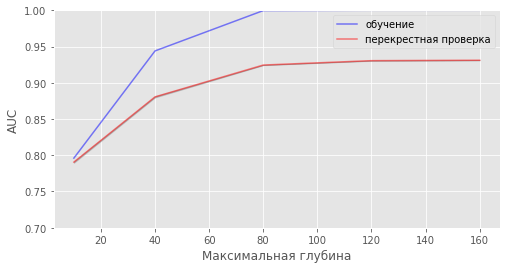

In [57]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_auc.mean(axis=1), alpha=0.5, color='blue', label='обучение')
ax.plot(max_depth_grid, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(max_depth_grid, test_auc.mean(axis=1) - test_auc.std(axis=1), test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_auc.mean(axis=1) - 2*test_auc.std(axis=1), test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.70,1.00])
ax.set_ylabel("AUC")
ax.set_xlabel("Максимальная глубина")

## min_samples_leaf_grid

In [59]:
# Создаем списки для сохранения AUC на обучающей и контрольной выборках
train_auc = []
test_auc = []
temp_train_auc = []
temp_test_auc = []
min_samples_leaf_grid = [1, 2, 3]

# Строим модели с разным минимальным количеством наблюдений в листе
for min_samples_leaf in min_samples_leaf_grid:
    print(f'\nНачали строить модель с минимальным числов листьев {min_samples_leaf}\n')
    rf = RandomForestClassifier(
        n_estimators=trees_grid[np.argmax(test_acc.mean(axis=1))], 
        random_state=42, 
        n_jobs=-1, 
        min_samples_leaf=min_samples_leaf, 
        verbose=1)
    temp_train_auc = []
    temp_test_auc = []
    for train_index, test_index in strat.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rf.fit(X_train, y_train)
        temp_train_auc.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1]))
        temp_test_auc.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
    train_auc.append(temp_train_auc)
    test_auc.append(temp_test_auc)

# Преобразуем списки в массивы NumPy
train_auc, test_auc = np.asarray(train_auc), np.asarray(test_auc)
print("Наилучшее значение AUC перекрестной проверки равно {:.3f} и достигается при минимальном количестве наблюдений в листе, равном {}".
      format(max(test_auc.mean(axis=1)), min_samples_leaf_grid[np.argmax(test_auc.mean(axis=1))]))


Начали строить модель с минимальным числов листьев 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 22.5min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    3.3s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    6.2s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    9.8s
[Parallel(n_job


Начали строить модель с минимальным числов листьев 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 12.1min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    3.4s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    5.3s
[Parallel(n_job


Начали строить модель с минимальным числов листьев 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.6min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.8s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    4.4s
[Parallel(n_job

Наилучшее значение AUC перекрестной проверки равно 0.931 и достигается при минимальном количестве наблюдений в листе, равном 1


[Parallel(n_jobs=16)]: Done 3000 out of 3000 | elapsed:    5.8s finished


Text(0.5, 0, 'Минимальное количество наблюдений в листе')

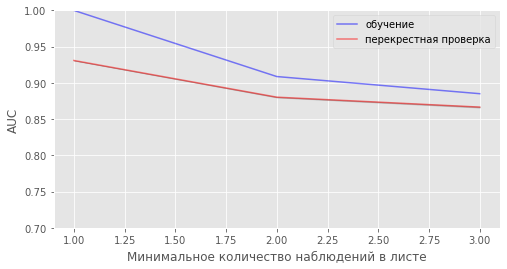

In [60]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_auc.mean(axis=1), alpha=0.5, color='blue', label='обучение')
ax.plot(min_samples_leaf_grid, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(min_samples_leaf_grid, test_auc.mean(axis=1) - test_auc.std(axis=1), test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_auc.mean(axis=1) - 2*test_auc.std(axis=1), test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.70,1.00])
ax.set_ylabel("AUC")
ax.set_xlabel("Минимальное количество наблюдений в листе")

In [61]:
# Деление до одного листа ВСЕГДА будет точнее любых вариантов

## GridSearchCV на основе рекомендуемых параметров

In [22]:
X = dummies_data.drop(columns=['ПродажаСостоялась_Да', 'ПродажаСостоялась_Нет'])
y = encoded_data['ПродажаСостоялась']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [24]:
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [1000, 2000, 3000],
    'max_depth': [80, 120, 160],
    'min_samples_leaf': [1]
}
grid_search = GridSearchCV(rf, param_grid, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [80, 120, 160], 'min_samples_leaf': [1],
                         'n_estimators': [1000, 2000, 3000]},
             scoring='roc_auc')

In [25]:
print("Наилучшее значение AUC: {:.2f}".format(grid_search.best_score_))
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))

Наилучшее значение AUC: 0.93
Наилучшие значения параметров: {'max_depth': 120, 'min_samples_leaf': 1, 'n_estimators': 1000}


In [26]:
test_score = roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1])
print("AUC на тестовой выборке: {:.2f}".format(test_score))

AUC на тестовой выборке: 0.93


 # Построение окончательной модели

In [27]:
X = dummies_data.drop(columns=['ПродажаСостоялась_Да', 'ПродажаСостоялась_Нет'])
y = encoded_data['ПродажаСостоялась']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=200)

In [28]:
finaly_forest = RandomForestClassifier(
    n_estimators=grid_search.best_params_.get('n_estimators'), 
    random_state=42, 
    n_jobs=-1,
    max_depth=grid_search.best_params_.get('max_depth'),
    min_samples_leaf=grid_search.best_params_.get('min_samples_leaf'), 
    warm_start = True,
    oob_score=True,
    verbose=1)

finaly_forest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.0min finished


RandomForestClassifier(max_depth=120, n_estimators=1000, n_jobs=-1,
                       oob_score=True, random_state=42, verbose=1,
                       warm_start=True)

In [29]:
print("Правильность на обучающей выборке: {:.3f}".format(finaly_forest.score(X_train, y_train)))
print("Правильность на контрольной выборке: {:.3f}".format(finaly_forest.score(X_test, y_test)))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    5.8s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:   10.7s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   13.9s finished


Правильность на обучающей выборке: 0.996


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    3.0s


Правильность на контрольной выборке: 0.861


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    4.0s finished


In [30]:
print("Правильность на обучающей выборке: {:.3f}".format(
    finaly_forest.score(X_train, y_train)))
print("OOB оценка правильности: {:.2f}".format(finaly_forest.oob_score_))
print("Правильность на контрольной выборке: {:.3f}".format(
    finaly_forest.score(X_test, y_test)))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    5.7s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:   10.6s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   13.8s finished


Правильность на обучающей выборке: 0.996
OOB оценка правильности: 0.86


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    3.4s


Правильность на контрольной выборке: 0.861


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    4.4s finished


In [31]:
print("AUC на обучающей выборке: {:.3f}".
      format(roc_auc_score(y_train, finaly_forest.predict_proba(X_train)[:, 1])))
print("AUC на контрольной выборке: {:.3f}".
      format(roc_auc_score(y_test, finaly_forest.predict_proba(X_test)[:, 1])))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    5.7s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:   10.6s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   13.7s finished


AUC на обучающей выборке: 1.000


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    3.3s


AUC на контрольной выборке: 0.932


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    4.4s finished


## Вывод
Модель полученная после продбора параметров не дала прироста точности и уменьшения AUC

# Сохраним на диск

In [32]:
# Сохраним модель на диск
joblib.dump(finaly_forest, "random_forest.joblib")

['random_forest.joblib']

In [33]:
# Сохраним набор столбцов данных
joblib.dump(dummies_data.columns, "columns_in_forest.joblib")

['columns_in_forest.joblib']

# Построение ROC-кривой и выбор оптимального порога

In [34]:
# Вычисляем с помощью метода predict_proba прогнозы
# для контрольной выборки и печатаем их
print("Форма вероятностей: {}".format(finaly_forest.predict_proba(X_test).shape))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    3.3s


Форма вероятностей: (36504, 2)


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    4.3s finished


In [35]:
# Выведем первые несколько элементов predict_proba
print("Спрогнозированные вероятности:\n{}".format(finaly_forest.predict_proba(X_test[:5])))

Спрогнозированные вероятности:
[[0.87475211 0.12524789]
 [0.05461341 0.94538659]
 [0.46354902 0.53645098]
 [0.14086431 0.85913569]
 [0.15051667 0.84948333]]


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    3.4s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    4.4s finished


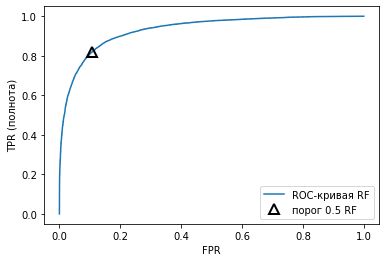

In [36]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, finaly_forest.predict_proba(X_test)[:, 1])

# Создаем заголовок ROC-кривой
plt.plot(fpr_rf, tpr_rf, label="ROC-кривая RF")
# Задаем название для оси x
plt.xlabel("FPR")
# Задаем название для оси y
plt.ylabel("TPR (полнота)")
# Задаем порог отсечения по умолчанию 0.5
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
# Строим ROC-кривую и наносим порог отсечения 0.5
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
         label="порог 0.5 RF", fillstyle="none", c='k', mew=2)
# Задаем расположение легенды
plt.legend(loc=4)

In [37]:
# Вычисляем значение AUC, передав функции roc_curve в качестве аргументов
# фактические значения зависимой переменной, записанные в y_test, 
# и вероятности положительного класса, вычисленные с помощью метода predict_proba
rf_auc = roc_auc_score(y_test, finaly_forest.predict_proba(X_test)[:, 1])
# Печатаем значение AUC
print("Значение AUC для контрольной выборки: {:.3f}".format(rf_auc))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    3.3s


Значение AUC для контрольной выборки: 0.932


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    4.2s finished


In [38]:
y_pred_lower_threshold = finaly_forest.predict_proba(X_test)[:, 1] > .2

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    3.4s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    4.3s finished


In [39]:
confusion2 = confusion_matrix(y_test, y_pred_lower_threshold)
print("Матрица ошибок для порога 0.2:\n{}".format(confusion2))

Матрица ошибок для порога 0.2:
[[11143  9411]
 [  454 15496]]


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    3.4s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    4.4s finished


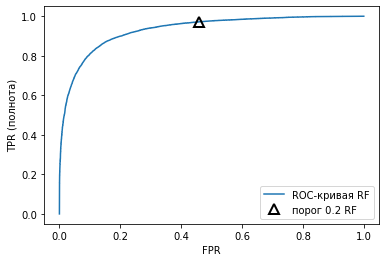

In [40]:
fpr_rf2, tpr_rf2, thresholds_rf2 = roc_curve(y_test, finaly_forest.predict_proba(X_test)[:, 1])

plt.plot(fpr_rf2, tpr_rf2, label="ROC-кривая RF")

plt.xlabel("FPR")
plt.ylabel("TPR (полнота)")
close_default_rf2 = np.argmin(np.abs(thresholds_rf2 - 0.2))
plt.plot(fpr_rf2[close_default_rf2], tpr_rf2[close_default_rf2], '^', markersize=10,
         label="порог 0.2 RF", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

In [41]:
# При предсказании будет использоватьс я порог точности _____
# Каждая команда решает сама, с какий % ошибки готова мириться

# Для информации
Модель с подобранными параметрами на LabelEncoder данных

In [42]:
# Получим списки по видам
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
print(f'Числовые столбы:\n{numerical_columns}')
print(f'\nКатегориальные столбы:\n{categorical_columns}')

Числовые столбы:
['ZakazanoShtuk', 'Cena', 'SummaZakazano', 'RastoynieOtNSK', 'otMoscow', 'ItogoProcentSkidki', 'cals', 'emails']

Категориальные столбы:
['PartnerKod', 'OsnovnoyManager', 'BiznesRegion', 'KreditIliPredoplata', 'StatusZakaza', 'SposobDostavki', 'NomenklaturaKodRealAndZakaz', 'VidNomenklatury', 'VidCeny', 'StavkaNDS', 'ПродажаСостоялась', 'Год + Месяц']


In [43]:
label_dict = dict() # Запишем объекты labelEncoder
# Преобразование с categorical_columns для newDF
label_encoded_data, label_dict = work_with_categorical_columns(
    data, categorical_columns, 'ПродажаСостоялась', 'OsnovnoyManager', label_dict)

# Теперь нужно склеить результат работы в новый DF:
encoded_data = pd.concat([data[numerical_columns], label_encoded_data], axis=1)

In [44]:
label_dict = dict() # Запишем объекты labelEncoder
# Преобразование с categorical_columns для newDF
label_encoded_data, label_dict = work_with_categorical_columns(
    data, categorical_columns, 'ПродажаСостоялась', 'OsnovnoyManager', label_dict)

# Теперь нужно склеить результат работы в новый DF:
encoded_data = pd.concat([data[numerical_columns], label_encoded_data], axis=1)

In [45]:
X = encoded_data.drop(columns='ПродажаСостоялась')
y = encoded_data['ПродажаСостоялась']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=200)

In [47]:
finaly_forest = RandomForestClassifier(
    n_estimators=grid_search.best_params_.get('n_estimators'), 
    random_state=42, 
    n_jobs=-1,
    max_depth=grid_search.best_params_.get('max_depth'),
    min_samples_leaf=grid_search.best_params_.get('min_samples_leaf'), 
    warm_start = True,
    oob_score=True,
    verbose=1)

finaly_forest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   16.1s finished


RandomForestClassifier(max_depth=120, n_estimators=1000, n_jobs=-1,
                       oob_score=True, random_state=42, verbose=1,
                       warm_start=True)

In [48]:
print("Правильность на обучающей выборке: {:.3f}".format(finaly_forest.score(X_train, y_train)))
print("Правильность на контрольной выборке: {:.3f}".format(finaly_forest.score(X_test, y_test)))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


Правильность на обучающей выборке: 0.996


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s


Правильность на контрольной выборке: 0.848


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.7s finished


In [49]:
print("Правильность на обучающей выборке: {:.3f}".format(
    finaly_forest.score(X_train, y_train)))
print("OOB оценка правильности: {:.2f}".format(finaly_forest.oob_score_))
print("Правильность на контрольной выборке: {:.3f}".format(
    finaly_forest.score(X_test, y_test)))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


Правильность на обучающей выборке: 0.996
OOB оценка правильности: 0.85


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.7s finished


Правильность на контрольной выборке: 0.848


In [50]:
print("AUC на обучающей выборке: {:.3f}".
      format(roc_auc_score(y_train, finaly_forest.predict_proba(X_train)[:, 1])))
print("AUC на контрольной выборке: {:.3f}".
      format(roc_auc_score(y_test, finaly_forest.predict_proba(X_test)[:, 1])))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


AUC на обучающей выборке: 1.000


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s


AUC на контрольной выборке: 0.922


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.6s finished
